# Exercise 01: SVD and Dimensionality Reduction

In this exercise, you will explore a "high-dimensional" (D=5) dataset
and determine:
* whether or not a good low-dimensional representation exists
* whether or not the data is linearly separable

As usual, let's start by installing and importing the stuff we'll need:

In [1]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U scikit-learn matplotlib seaborn pandas

  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 6.8 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x8

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Now we'll create some data to analyze.

You don't need to understand this code in detail,
but you might want to revisit it after you finish the exercise
to see if you can figure out what I did and why I did it.

In [3]:
## create a 5D normal unit vector
n = np.array([[0.5, 0.5, 0.5, 0.5, 0.5]]).T #np.random.rand(5,1)
n_hat = n / np.linalg.norm(n)
d = 10.0*np.random.rand(1,1)

## create two unit vectors normal to n_hat
a_1      = np.array([[0.5, -0.5, -0.5, -0.5, 0.5]]).T #np.random.rand(5,1)
a_1_orth = a_1 - np.dot(n_hat.T, a_1)*n_hat
a_1_hat  = a_1_orth / np.linalg.norm(a_1_orth)

a_2            = np.array([[-0.5, 0.5, 0.5, 0.5, -0.5]]).T #np.random.rand(5,1)
a_2_orth_1     = a_2 - np.dot(n_hat.T, a_2)*n_hat
a_2_orth_2     = a_2_orth_1 - np.dot(a_1_hat.T, a_2_orth_1)*a_1_hat
a_2_hat        = a_2_orth_2 / np.linalg.norm(a_2_orth_2)

print('n_hat =\n{}'.format(n_hat))
print('a_1_hat =\n{}'.format(a_1_hat))
print('a_2_hat =\n{}'.format(a_2_hat))

n_hat =
[[0.4472136]
 [0.4472136]
 [0.4472136]
 [0.4472136]
 [0.4472136]]
a_1_hat =
[[ 0.54772256]
 [-0.36514837]
 [-0.36514837]
 [-0.36514837]
 [ 0.54772256]]
a_2_hat =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [4]:
## create clusters of random data
np.random.seed(10)

cluster_infos = [
    ( 0.0, 0.0, 0.2, 1),
    (+6.0, 0.0, 0.7, 2),
    (-6.0, 0.0, 0.7, 3),
    (+2.0,+2.0, 0.2, 4),
    (+2.0,-2.0, 0.2, 5),
    (-2.0,+2.0, 0.2, 6),
    (-2.0,-2.0, 0.2, 7),
]
N_samples = 100

coord_offset = np.array([[3.0, 0.0, -9.0, 4.0, 30.0]])

all_samples = [];
for (coord_1,coord_2,sigma,categ) in cluster_infos:
    m = coord_1*a_1_hat + coord_2*a_2_hat
    C = np.diagflat(sigma*sigma*np.ones((1,5)))
    samples = np.random.default_rng().multivariate_normal(np.zeros((5,)), C, N_samples) + m.T + coord_offset;
    samples = np.concatenate((samples,categ*np.ones((samples.shape[0],1))), axis=1)
    all_samples.append(np.copy(samples))
    
samples = np.concatenate(all_samples, axis=0)
sample_data = samples[:,0:5]
sample_targets = samples[:,5]

Each row of `samples` contains one 5D data point and a classification category: 

In [5]:
samples.shape

(700, 6)

Let's convert `samples` to a pandas dataframe and take a look at it.

In [6]:
import pandas as pd
import seaborn as sns

sns.set(style='ticks', color_codes=True)
df = pd.DataFrame(
    data=samples,
    columns=['c_'+str(n) for n in range(5)] + ['target']
)

/tmp/ipykernel_24982/3607304137.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
df

,c_0,c_1,c_2,c_3,c_4,target
0,3.012930,-0.152207,-9.406230,4.045114,30.074168,1.0
1,2.951012,-0.300182,-8.972249,4.142464,30.060803,1.0
2,2.685967,0.485662,-8.881218,3.677116,29.983578,1.0
3,2.734856,-0.014133,-8.924933,4.067903,29.894091,1.0
4,2.987258,0.254811,-8.971777,4.213807,30.022691,1.0
...,...,...,...,...,...,...
695,0.277594,0.512417,-8.037464,4.830040,27.625936,7.0
696,0.358232,0.777672,-7.987137,4.896605,27.478315,7.0
697,0.619583,1.092779,-8.202184,5.013165,27.545944,7.0
698,0.504363,0.259710,-8.098608,4.452340,27.217410,7.0


Time for some `pairplots`:

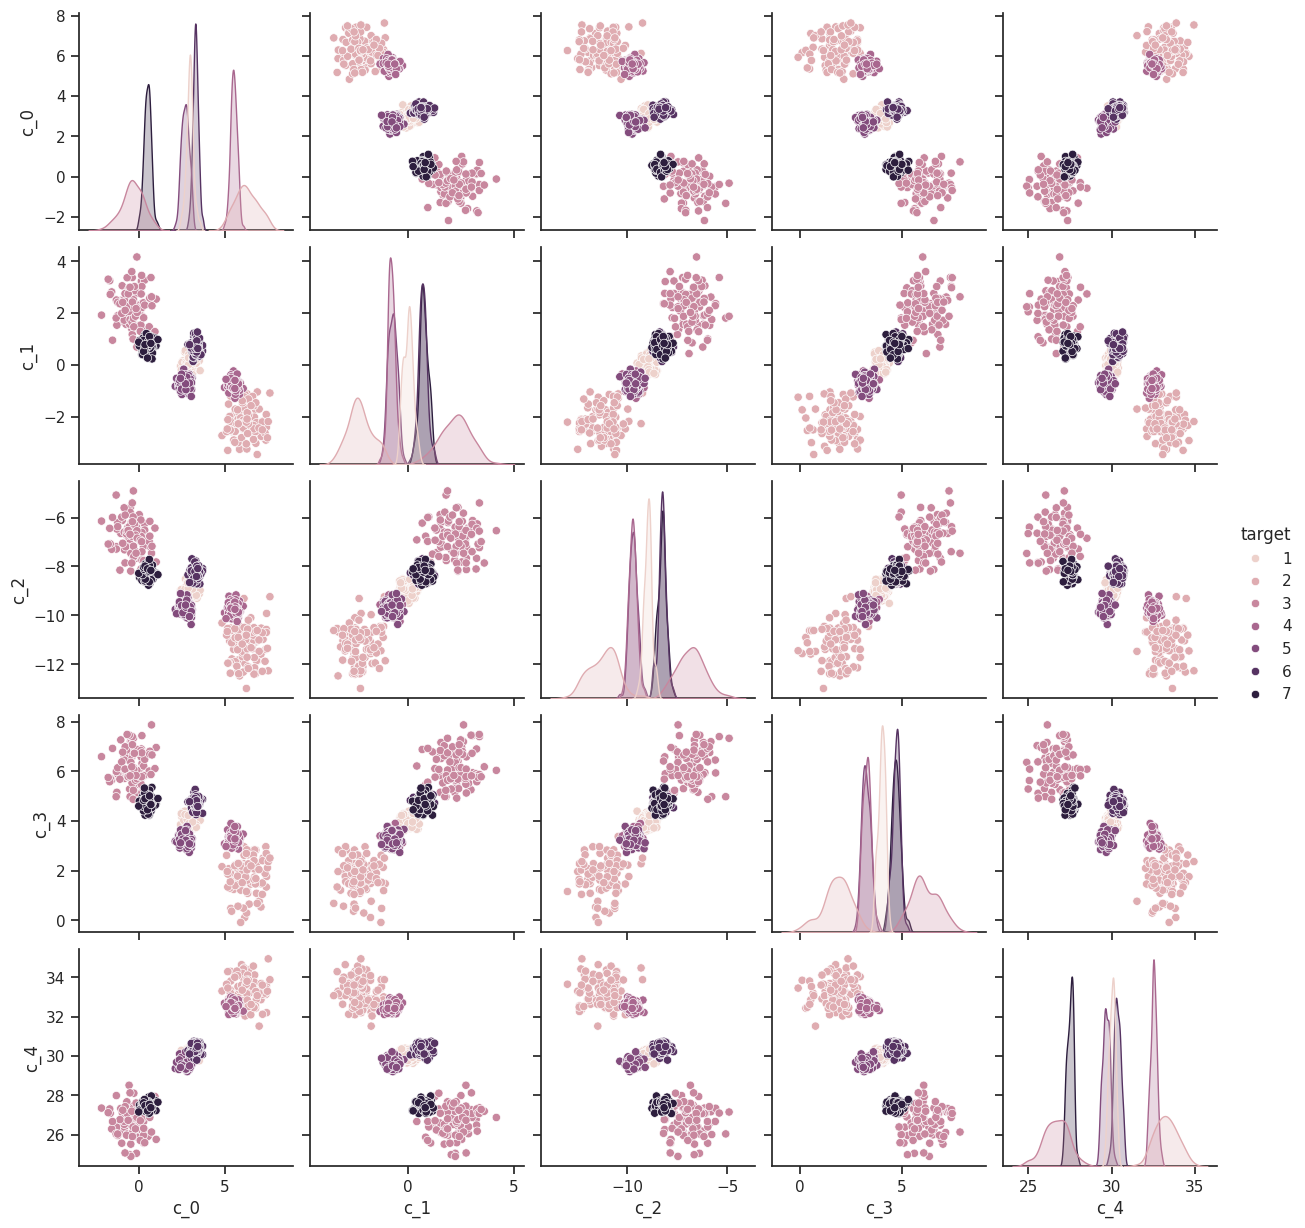

In [8]:
g = sns.pairplot(df, hue='target');

**Based on the above plots, are the categories separable?  Why or why not?**


This data is not separable based on the plots above. There is alot of overlap. 

Let's see if we can reduce the dimensionality of this data
by applying Singular Value Decomposition (SVD)
to its covariance matrix:

In [9]:
M = sample_data;
CM = np.dot(M.T, M)
U,S,Vh = np.linalg.svd(CM,full_matrices=True, compute_uv=True)

In [10]:
S

array([7.08495786e+05, 5.76383403e+03, 5.48826882e+02, 1.14001406e+02,
       1.00419360e+02])

**Based on the singular values in the `S` vector above,
what's the smallest number of dimensions we can keep
and still retain the vast majority of the data's information content?
How did you arrive at that value?**


I'd say the smallest number of dimensions that we can keep and still retain the majority of the data's information is 1 dimension. 7e+05 is above 99% of the data.

Let's see what happens if we retain only 2 dimensions...

We'll create a new matrix using the first 2 singular values:

In [11]:
P = np.dot(np.diagflat(S[0:2]), Vh[0:2,:])

In [21]:
print(Vh[0:2,:])

[[-0.0989649   0.0029681   0.28484763 -0.12230335 -0.94556906]
 [ 0.67312429 -0.45169273 -0.20065607 -0.54664314 -0.06160995]]


In [22]:
print(S[0:2])

[708495.78640794   5763.83402856]


In [12]:
P

array([[-7.01162123e+04,  2.10288867e+03,  2.01813347e+05,
        -8.66514096e+04, -6.69931698e+05],
       [ 3.87977671e+03, -2.60348192e+03, -1.15654829e+03,
        -3.15076031e+03, -3.55109543e+02]])

**What is the shape of `P`?  What does that tell us about the effect `P` has on its inputs?  What does this matrix do for us?** (Hint: Why did I call it `P`?)

*Not too sure about this.*
P is a 2 x 5 matrix. The inputs have to be a 5D matrix. 

Let's apply `P` to our data and take a look at the 2D scatterplot.

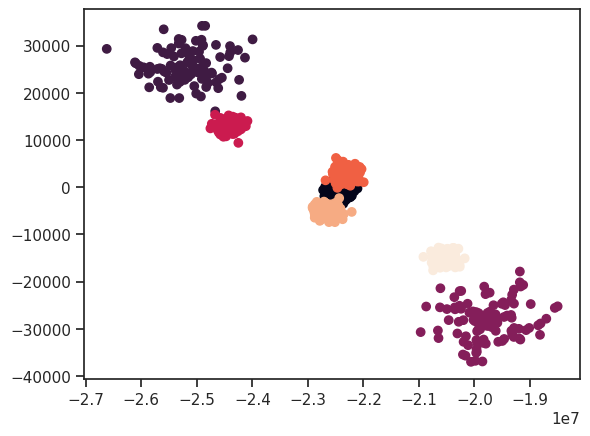

In [13]:
new_data = np.dot(P,M.T)
plt.scatter(new_data[0,:], new_data[1,:], c=samples[:,5]);

**Based on the above plot, did our use of SVD significantly improve the separability of our data?  Why or why not?**

It does improve the separability of some of the data, not all.

Our original data wasn't centered at the origin nor were the axes scaled by their standard deviations.  Let's do that now and see if it impacts the results:

In [23]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(sample_data)
scaled_sample_data = scaler.transform(sample_data)
scaled_samples = np.concatenate((scaled_sample_data,samples[:,5:6]), axis=1)

In [24]:
M = scaled_sample_data;
CM = np.dot(M.T, M)
U,S,Vh = np.linalg.svd(CM,full_matrices=True, compute_uv=True)

In [25]:
S

array([3130.90142943,  233.81357047,   60.81311832,   53.34564925,
         21.12623253])

**Based on the singular values above, what is a reasonable estimate of the number of useful data dimensions?**

2

Let's take a look at the new 2D scatter plot:

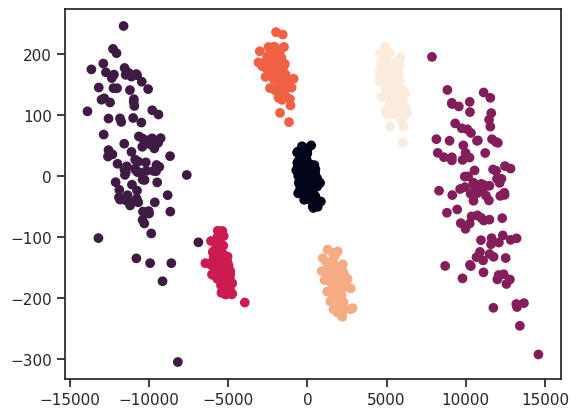

In [26]:
P = np.dot(np.diagflat(S[0:2]), Vh[0:2,:])
new_M = np.dot(P,M.T)
plt.scatter(new_M[0,:], new_M[1,:], c=samples[:,5]);

**Based on the above plot, is our data representable in 2D?  Is it separable in 2D?**

Yes the data is representable in 2D. Yes,it is separable.

**Why did data normalization have such a large impact on SVD?**

It was able to put the data on the same scale which makes the data easily separable.

**Is this reduction from 5D to 2D lossy or lossless?** (Feel free to google those terms if you need to.)

Lossy. I don't think that we can get the data back that we got rid of. 

**Why would we want to reduce the dimensionality of our data? What advantages does it bring, if any?  What disadvantages?**

Reducing the dimensionality allows us to focus on what the majority of the data is doing. The disadvantage to this is that we are losing data that we can't get back and may miss out on data that could possibly be meaningful.

**What did you think of this exercise?**

YOUR ANSWER HERE.

Good exercise. Got caught up on one question and still trying to wrap my had around the math of SVD but overall, I feel like I gained a basic understanding of SVD, data normalization, and dimensionality reduction.